This notebook purpose is to try out AutoGluon package open sourced by AWS. The project details is available in link below

https://autogluon.mxnet.io/


In [14]:
#!pip install --upgrade mxnet
# !pip install autogluon

In [15]:
import autogluon as ag

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from scipy import stats

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import  KNeighborsRegressor
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg

# Calculo de metricas
# ==============================================================================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn import metrics

# Configuración warnings
# ==============================================================================
import warnings
pd.options.mode.chained_assignment = None  # default='warn'
# warnings.filterwarnings('ignore')

In [16]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [17]:
folder = ""
parametro = 'temperatura'
output=parametro
inputs = [
          'fecha', 'temperatura',
          'ambiente', 'nivel'
          ]
usecols = inputs.copy()

datos = pd.read_csv(folder + "laguna_datos_horarios_rellenos" + ".csv",sep=',', usecols=usecols)

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%d/%m/%Y %H:%M')
#datos = datos.set_index('fecha')
datos['time_stamp'] = pd.to_datetime(datos['fecha'], format='%d/%m/%Y %H:%M')
datos = datos.drop(columns=["fecha"])
#datos = datos.rename(columns={'x': 'y'})
#datos = datos.asfreq('H')
#datos = datos.sort_index()
datos["t-1"] = datos["temperatura"].shift(1)
datos = datos.dropna()
datos["item_id"] = "H1"

datos.info()

#datos = datos.iloc[254:]

#datos.head()
datos

<class 'pandas.core.frame.DataFrame'>
Index: 2112 entries, 1 to 2112
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   temperatura  2112 non-null   float64       
 1   ambiente     2112 non-null   float64       
 2   nivel        2112 non-null   float64       
 3   time_stamp   2112 non-null   datetime64[ns]
 4   t-1          2112 non-null   float64       
 5   item_id      2112 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 115.5+ KB


,temperatura,ambiente,nivel,time_stamp,t-1,item_id
1,31.4700,21.780000,51.0,2023-06-17 01:00:00,31.5000,H1
2,31.2350,21.201000,47.8,2023-06-17 02:00:00,31.4700,H1
3,31.2950,22.439250,52.0,2023-06-17 03:00:00,31.2350,H1
4,31.3750,23.058375,50.0,2023-06-17 04:00:00,31.2950,H1
5,31.3150,23.677500,48.0,2023-06-17 05:00:00,31.3750,H1
...,...,...,...,...,...,...
2108,31.5375,25.820000,34.0,2023-09-12 20:00:00,31.1600,H1
2109,31.4325,25.310000,36.0,2023-09-12 21:00:00,31.5375,H1
2110,31.3350,23.930000,35.0,2023-09-12 22:00:00,31.4325,H1
2111,31.1775,23.700000,35.0,2023-09-12 23:00:00,31.3350,H1


<Axes: >

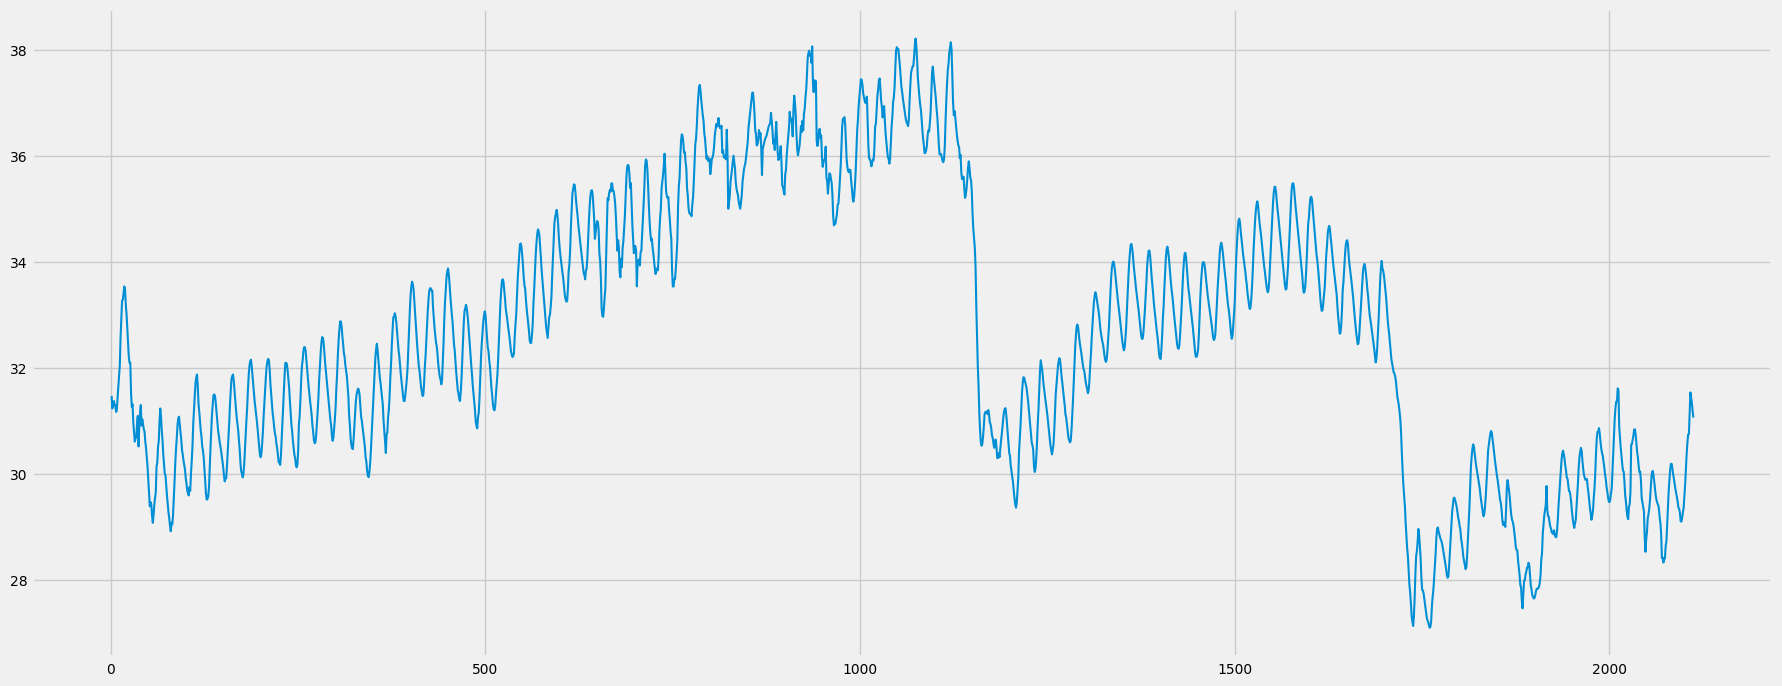

In [18]:
#CON ESTO PUEDO CONTROLAR CUAL ES EL DATO FINAL Y DEJARLO EN TENDENCIA ASCENDENTE O DESCENDENTE
#datos = datos.iloc[:-10]
datos_originales = datos
#datos = datos.diff().dropna()

fig, ax = plt.subplots(figsize=(20, 8))
datos['temperatura'].plot(ax=ax, label='train')


In [19]:
entrenar = 420

In [20]:
train_data = TimeSeriesDataFrame.from_data_frame(
    datos.iloc[:-entrenar],
    id_column="item_id",
    timestamp_column="time_stamp"
)
train_data.head()

temperatura   ambiente  nivel     t-1
item_id timestamp                                                 
H1      2023-06-17 01:00:00       31.470  21.780000   51.0  31.500
        2023-06-17 02:00:00       31.235  21.201000   47.8  31.470
        2023-06-17 03:00:00       31.295  22.439250   52.0  31.235
        2023-06-17 04:00:00       31.375  23.058375   50.0  31.295
        2023-06-17 05:00:00       31.315  23.677500   48.0  31.375

In [21]:
predictor = TimeSeriesPredictor(
    prediction_length=entrenar,
    path="autogluon-m4-hourly",
    target="temperatura",
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'autogluon-m4-hourly'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       10.75 GB / 12.67 GB (84.8%)
Disk Space Avail:   46.70 GB / 78.19 GB (59.7%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 420,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'temperatura',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'H'
Provided train_data has 1692 rows, 1 t

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

	-4.1433       = Validation score (-MASE)
	32.65   s     = Training runtime
	14.24   s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. Training for up to 108.6s of the 434.5s of remaining time.
	-8.3347       = Validation score (-MASE)
	103.62  s     = Training runtime
	0.09    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 110.2s of the 330.7s of remaining time.
	-2.7154       = Validation score (-MASE)
	74.71   s     = Training runtime
	2.36    s     = Validation (prediction) runtime
Training timeseries model PatchTST. Training for up to 126.8s of the 253.6s of remaining time.
	-3.5243       = Validation score (-MASE)
	56.73   s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'DeepAR': 0.58, 'DynamicOptimizedTheta': 0.25, 'NPTS': 0.05, 'SeasonalNaive': 0.02, 'TemporalFusionTransformer': 0.1}
	-2.6613       = Validation 

In [22]:
predictions = predictor.predict(train_data)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean        0.1        0.2        0.3  \
item_id timestamp                                                         
H1      2023-08-26 13:00:00  33.400035  32.389174  32.742660  33.009247   
        2023-08-26 14:00:00  33.529478  32.521676  32.972743  33.202027   
        2023-08-26 15:00:00  33.692241  32.652849  33.013476  33.287462   
        2023-08-26 16:00:00  33.848923  32.808952  33.214704  33.505151   
        2023-08-26 17:00:00  34.072590  33.057350  33.412865  33.694580   

                                   0.4        0.5        0.6        0.7  \
item_id timestamp                                                         
H1      2023-08-26 13:00:00  33.244828  33.400035  33.570290  33.842915   
        2023-08-26 14:00:00  33.370255  33.529478  33.689219  33.924917   
        2023-08-26 15:00:00  33.497283  33.692241  33.848025  34.103434   
        2023-08-26 16:00:00  33.706238  33.848923  34.030630  34.240403   
        2023-08-26 17:00:00  33.881285  34.072590  34.261984  34.490229   

                                   0.8        0.9  
item_id timestamp                                  
H1      2023-08-26 13:00:00  34.001548  34.292342  
        2023-08-26 14:00:00  34.173432  34.435577  
        2023-08-26 15:00:00  34.336185  34.738929  
        2023-08-26 16:00:00  34.475745  34.828185  
        2023-08-26 17:00:00  34.735422  35.096973

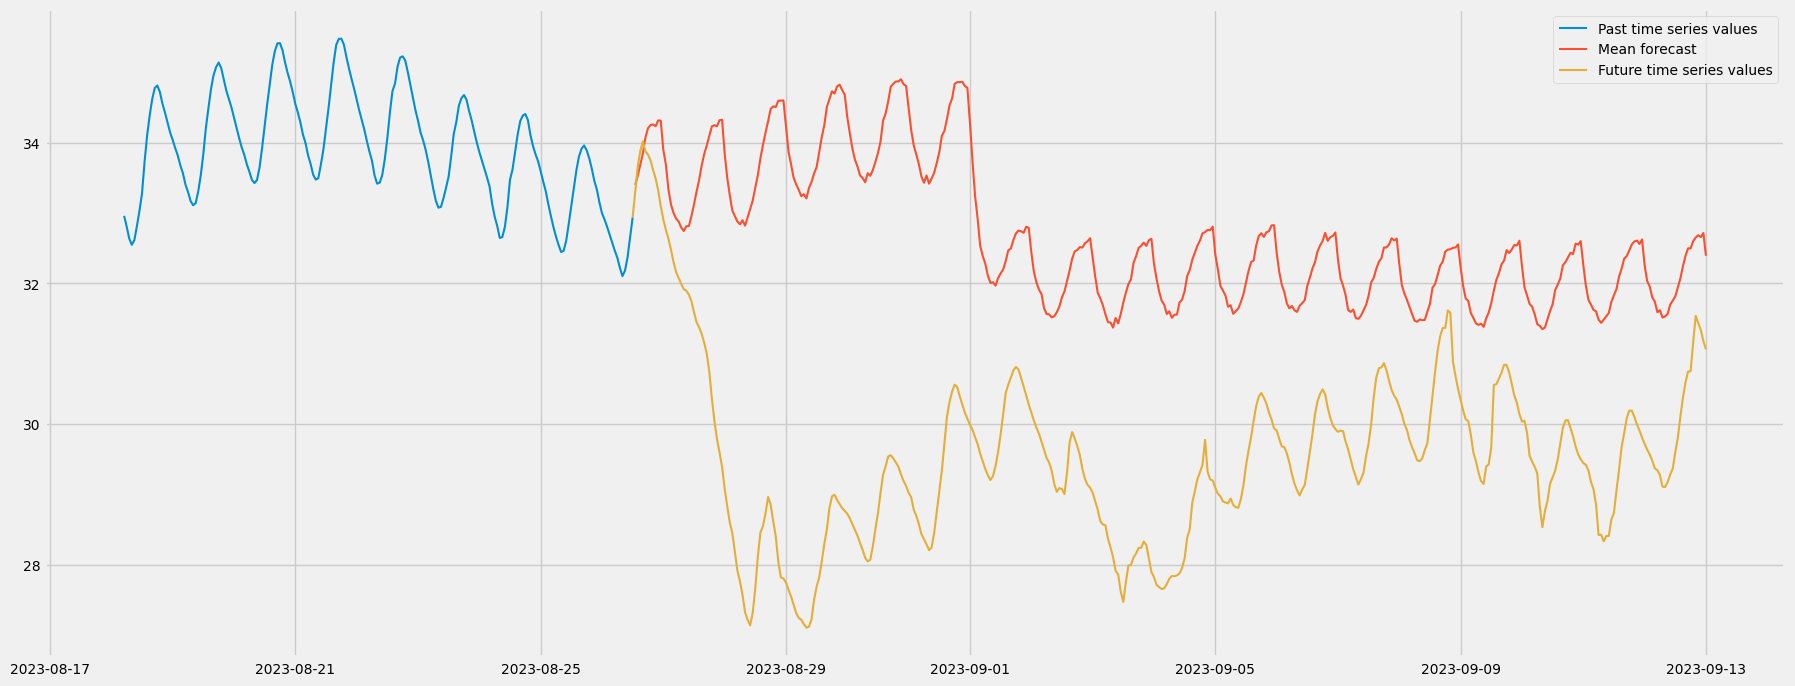

In [23]:
import matplotlib.pyplot as plt

# TimeSeriesDataFrame can also be loaded directly from a file
test_data = TimeSeriesDataFrame.from_data_frame(
    datos,
    id_column="item_id",
    timestamp_column="time_stamp"
)

y_train = train_data.loc["H1"]["temperatura"].iloc[-200:]
y_test = test_data.loc["H1"]["temperatura"].iloc[-entrenar-1:]

y_pred = predictions.loc["H1"]["mean"]

plt.figure(figsize=(20, 8))

plt.plot(y_train, label="Past time series values")
plt.plot(y_pred, label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.legend();


In [26]:
y_train

timestamp
2023-08-18 05:00:00    32.9600
2023-08-18 06:00:00    32.8075
2023-08-18 07:00:00    32.6375
2023-08-18 08:00:00    32.5475
2023-08-18 09:00:00    32.6125
                        ...   
2023-08-26 08:00:00    32.1025
2023-08-26 09:00:00    32.1800
2023-08-26 10:00:00    32.3675
2023-08-26 11:00:00    32.6475
2023-08-26 12:00:00    32.9375
Name: temperatura, Length: 200, dtype: float64

In [38]:
start_date = "2023-08-08 16:00"
end_date = "2023-09-13 00:00"
date_range = pd.date_range(start=start_date, end=end_date, freq='H')

date_range

DatetimeIndex(['2023-08-08 16:00:00', '2023-08-08 17:00:00',
               '2023-08-08 18:00:00', '2023-08-08 19:00:00',
               '2023-08-08 20:00:00', '2023-08-08 21:00:00',
               '2023-08-08 22:00:00', '2023-08-08 23:00:00',
               '2023-08-09 00:00:00', '2023-08-09 01:00:00',
               ...
               '2023-09-12 15:00:00', '2023-09-12 16:00:00',
               '2023-09-12 17:00:00', '2023-09-12 18:00:00',
               '2023-09-12 19:00:00', '2023-09-12 20:00:00',
               '2023-09-12 21:00:00', '2023-09-12 22:00:00',
               '2023-09-12 23:00:00', '2023-09-13 00:00:00'],
              dtype='datetime64[ns]', length=849, freq='H')

In [49]:
y_test

timestamp
2023-08-26 12:00:00    32.9375
2023-08-26 13:00:00    33.2975
2023-08-26 14:00:00    33.6600
2023-08-26 15:00:00    33.8825
2023-08-26 16:00:00    34.0175
                        ...   
2023-09-12 20:00:00    31.5375
2023-09-12 21:00:00    31.4325
2023-09-12 22:00:00    31.3350
2023-09-12 23:00:00    31.1775
2023-09-13 00:00:00    31.0625
Name: temperatura, Length: 421, dtype: float64

In [50]:
y_pred

timestamp
2023-08-26 13:00:00    33.400035
2023-08-26 14:00:00    33.529478
2023-08-26 15:00:00    33.692241
2023-08-26 16:00:00    33.848923
2023-08-26 17:00:00    34.072590
                         ...    
2023-09-12 20:00:00    32.651211
2023-09-12 21:00:00    32.683310
2023-09-12 22:00:00    32.657042
2023-09-12 23:00:00    32.715793
2023-09-13 00:00:00    32.392027
Name: mean, Length: 420, dtype: float64

In [39]:
y_train = train_data.loc["H1"]["temperatura"].iloc[1264:]
y_test = test_data.loc["H1"]["temperatura"].iloc[-entrenar-1:]

In [40]:
plt.rcdefaults()

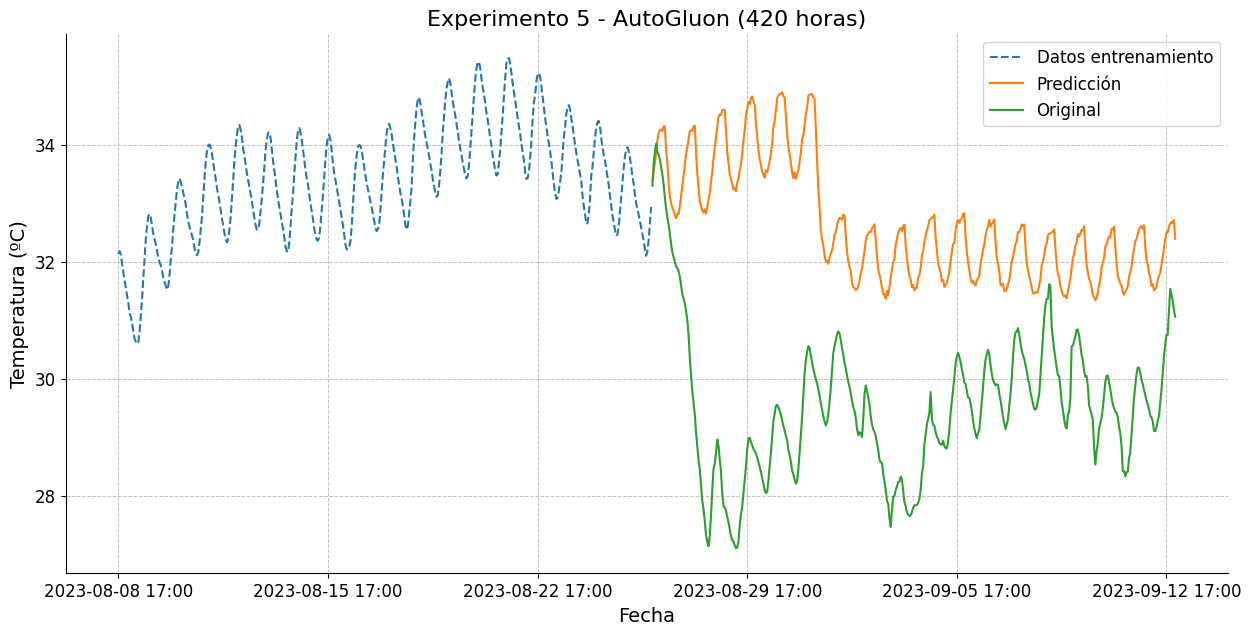

In [51]:
# Plot predictions, actual values, and input data
date_range = y_train.index.union(y_test.index)

plt.figure(figsize=(15,7))

y_pred = predictions.loc["H1"]["mean"]

plt.plot(y_train, label="Datos entrenamiento", linestyle='--')
plt.plot(y_pred, label='Predicción')
plt.plot(y_test[1:], label='Original')

# Configuración de los ejes y títulos
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Temperatura (ºC)', fontsize=14)
plt.title(f'Experimento 5 - AutoGluon (420 horas)', fontsize=16)

# Quitar los bordes superior y derecho
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar el tamaño de la leyenda
plt.legend(fontsize=12)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticks(date_range[::168])  # Mostrar ticks cada 168 horas (una semana)
ax.set_xticklabels(date_range[::168].strftime('%Y-%m-%d %H:%M'))

# Configurar la cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='grey', alpha = 0.5)

# Guardar el gráfico en una carpeta con buena resolución
plt.savefig(f"exp5.png", dpi=300, bbox_inches='tight')
plt.show()


In [52]:
# Calculate MSE
mse = mean_squared_error(y_test[1:], y_pred)

print(f"MSE: {mse}")

# Calculate MAE
mae = np.mean(np.abs(y_test[1:] - y_pred))
print(f"MAE: {mae}")

#Caclular R2
r2 = metrics.r2_score(y_test[1:], y_pred)
print(f"R2: {r2}")

MSE: 11.979011212457308
MAE: 3.1141392206951966
R2: -6.480410258919215


In [24]:
# The test score is computed using the last
# prediction_length=48 timesteps of each time series in test_data
predictor.leaderboard(train_data, silent=True)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.951544,-2.661336,6.973439,8.855266,1.144085,13
1,DeepAR,-1.089073,-2.715355,2.637644,2.364035,74.714377,11
2,PatchTST,-1.124864,-3.524264,0.196431,0.069672,56.730859,12
3,NPTS,-1.405877,-4.109217,3.672050,5.248512,2.647009,5
4,RecursiveTabular,-2.278083,-4.537423,14.808547,14.241109,16.450135,2
5,Chronos[base],-3.202335,-4.143296,17.742006,14.235915,32.654433,9
6,AutoETS,-3.395010,-3.940465,3.180427,1.984706,16.009048,7
7,SeasonalNaive,-3.586433,-4.016671,0.088073,0.073913,0.094175,1
8,DirectTabular,-3.668676,-5.881228,0.206868,0.124304,2.771487,3
9,DynamicOptimizedTheta,-3.797430,-4.666399,0.333570,1.081360,21.970810,6
